In [17]:
import numpy as np
import matplotlib.pyplot as plt
from Structure import *
from Utils import *
import scipy.optimize as scopt
import time

In [18]:
def boundary_residual_circle(interior_offsets_vector):
    global width 
    global height 
    global target_phi 
    global structure
    global boundary_points
    global corners
    global boundary_offsets
    global dual_bound_inds
    global reduced_dual_bound_inds
    global boundary_points_vector
    
    # Reshape flattened offsets to 2D grid: (width*height,) -> (height, width)
    interior_offsets = np.reshape(interior_offsets_vector, (height, width))
    
    # update the pattern using the linear inverse design method with the input offset
    structure.linear_inverse_design(boundary_points_vector, corners, interior_offsets, boundary_offsets)
    structure.make_hinge_contact_points()

    # get the second contracted state
    deployed_points, deployed_hinge_contact_points = structure.layout(phi=0.0) 
    
    # assess the circularity using sum( (r-r_mean)^2 )
    distance_from_center = np.sqrt(
        np.square(
            np.array(deployed_points[reduced_dual_bound_inds,0]-np.mean(deployed_points[reduced_dual_bound_inds,0]))
            ) + 
        np.square(
                np.array(deployed_points[reduced_dual_bound_inds,1]-np.mean(deployed_points[reduced_dual_bound_inds,1]))
            )
        )
    residuals = distance_from_center - np.mean(distance_from_center)
    
    # (Alternative way) assess the circularity using (L^2/(4*pi*A) - 1)^2
    # reduced_dual_bound_inds_shifted = reduced_dual_bound_inds[1:]
    # reduced_dual_bound_inds_shifted.append(reduced_dual_bound_inds[0])
    # edgelengths = np.sqrt(np.square(np.array(deployed_points[reduced_dual_bound_inds,0]-deployed_points[reduced_dual_bound_inds_shifted,0])) + np.square(np.array(deployed_points[reduced_dual_bound_inds,1]-deployed_points[reduced_dual_bound_inds_shifted,1])))
    # L = np.sum(edgelengths)
    # pgon = geom.Polygon(zip(deployed_points[reduced_dual_bound_inds,0], deployed_points[reduced_dual_bound_inds,1]))
    # A = pgon.area
    # residuals = L**2/(4*np.pi*A) - 1
    
    return residuals

In [19]:
# set the pattern size
width = 9
height = 9

# create a square kirigami structure and get the required information for the optimization
structure = MatrixStructure(num_linkage_rows=height, num_linkage_cols=width)
bound_linkage_inds = [structure.get_boundary_linkages(i) for i in range(4)]
bound_directions = np.array([[-1.0, 0.0], [0.0, -1.0], [1.0, 0.0], [0.0, 1.0]])
boundary_points = []
corners = []
for i, bound in enumerate(bound_linkage_inds):
    local_boundary_points = []
    for j, linkage_ind in enumerate(bound):
        p = structure.is_linkage_parallel_to_boundary(linkage_ind[0], linkage_ind[1], i)
        if j == 0:
            corner = np.array([linkage_ind[1], -linkage_ind[0]]) + bound_directions[i]
            if not p:
                corner += bound_directions[(i-1)%4]
            corners.append(corner)
        if not p:
            point = np.array([linkage_ind[1], -linkage_ind[0]]) + bound_directions[i]
            local_boundary_points.append(point)
    boundary_points.append(np.vstack(local_boundary_points))
corners = np.vstack(corners)
boundary_offsets = [[0.0]*height, [0.0]*width, [0.0]*height, [0.0]*width]
boundary_points_vector = np.vstack(boundary_points)

In [20]:
interior_offsets_initial = np.power(10, np.random.rand(height,width) * 2 - 1) - 1
# create random offsets within (-0.9, 0.9)
# interior_offsets = np.random.rand(height, width) * 1.8 - 0.9

# get the resulting random kirigami pattern using the linear inverse design method
structure.linear_inverse_design(np.vstack(boundary_points), corners, interior_offsets_initial, boundary_offsets)

structure.make_hinge_contact_points()
deployed_points, deployed_hinge_contact_points = structure.layout(phi=0.0) 
dual_bound_inds = []
for bound_ind in range(4):
    dual_bound_inds.extend(structure.get_dual_boundary_node_inds(bound_ind))
reduced_dual_bound_inds = []
for i, ind in enumerate(dual_bound_inds):    
    next_i = (i+1) % len(dual_bound_inds)    
    next_ind = dual_bound_inds[next_i]    
    if norm(deployed_points[ind] - deployed_points[next_ind]) > 1e-10:
        reduced_dual_bound_inds.append(ind)


This Matrix is not invertible
Det: -3.8390510138530225e+26


Text(0.5, 1.0, 'Initial Contracted State (φ = π)')

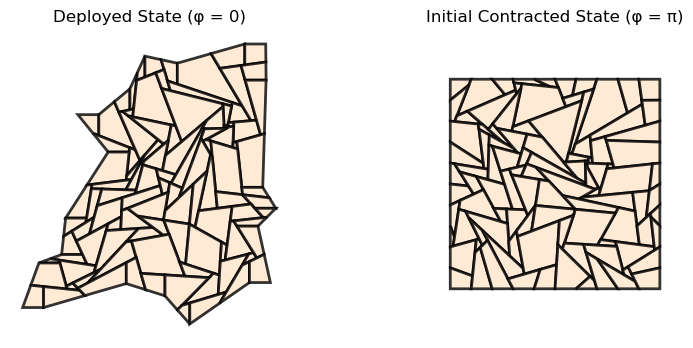

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(1.2*4*2, 4), sharey=True)

deployed_points, deployed_hinge_contact_points = structure.layout(0)
deployed_points = rotate_points(deployed_points, np.array([0, 0]), -(np.pi - 0)/2.0)

deployed_points[:,0] = deployed_points[:,0] - (np.max(deployed_points[:,0])+np.min(deployed_points[:,0]))/2
deployed_points[:,1] = deployed_points[:,1] - (np.max(deployed_points[:,1])+np.min(deployed_points[:,1]))/2

plot_structure(deployed_points, structure.quads, structure.linkages, axs[0])
axs[0].set_aspect('equal')
axs[0].set_title("Deployed State (φ = 0)")

deployed_points, deployed_hinge_contact_points = structure.layout(np.pi)
deployed_points = rotate_points(deployed_points, np.array([0, 0]), -(np.pi - np.pi)/2.0)

deployed_points[:,0] = deployed_points[:,0] - (np.max(deployed_points[:,0])+np.min(deployed_points[:,0]))/2
deployed_points[:,1] = deployed_points[:,1] - (np.max(deployed_points[:,1])+np.min(deployed_points[:,1]))/2

plot_structure(deployed_points, structure.quads, structure.linkages, axs[1])
axs[1].set_aspect('equal')
axs[1].set_title("Initial Contracted State (φ = π)")

In [22]:
result = scopt.least_squares(boundary_residual_circle, np.zeros(width*height),bounds=(-np.ones(width*height),np.inf),xtol = 1e-8,verbose=2)
opt_offsets = np.reshape(result.x, (height, width))

structure.linear_inverse_design(np.vstack(boundary_points), corners, opt_offsets, boundary_offsets)

structure.assign_node_layers()
structure.assign_quad_genders()
structure.make_hinge_contact_points()



This Matrix is not invertible
Det: -7.089727956532931e+21
This Matrix is not invertible
Det: -7.089728004460781e+21
This Matrix is not invertible
Det: -7.089728008146407e+21
This Matrix is not invertible
Det: -7.089728008937706e+21
This Matrix is not invertible
Det: -7.089728009209835e+21
This Matrix is not invertible
Det: -7.089728009355471e+21
This Matrix is not invertible
Det: -7.089728009501308e+21
This Matrix is not invertible
Det: -7.089728009773588e+21
This Matrix is not invertible
Det: -7.089728010564534e+21
This Matrix is not invertible
Det: -7.089728014250261e+21
This Matrix is not invertible
Det: -7.089728008146407e+21
This Matrix is not invertible
Det: -7.089728008274563e+21
This Matrix is not invertible
Det: -7.089728008844058e+21
This Matrix is not invertible
Det: -7.08972800915417e+21
This Matrix is not invertible
Det: -7.089728009355471e+21
This Matrix is not invertible
Det: -7.089728009556873e+21
This Matrix is not invertible
Det: -7.089728009867185e+21
This Matrix is 

Text(0.5, 1.0, 'Initial Contracted State (φ = π)')

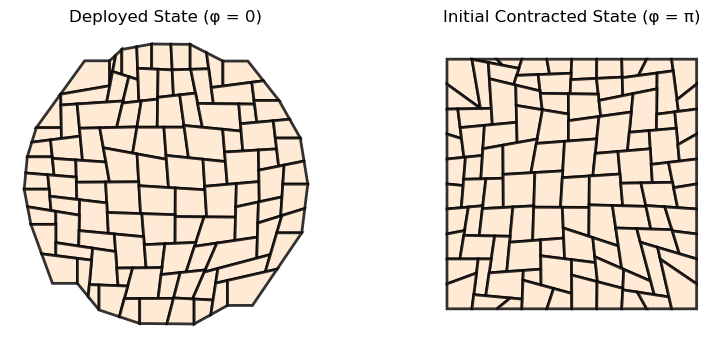

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(1.2*4*2, 4), sharey=True)

deployed_points, deployed_hinge_contact_points = structure.layout(0)
deployed_points = rotate_points(deployed_points, np.array([0, 0]), -(np.pi - 0)/2.0)

deployed_points[:,0] = deployed_points[:,0] - (np.max(deployed_points[:,0])+np.min(deployed_points[:,0]))/2
deployed_points[:,1] = deployed_points[:,1] - (np.max(deployed_points[:,1])+np.min(deployed_points[:,1]))/2

plot_structure(deployed_points, structure.quads, structure.linkages, axs[0])
axs[0].set_aspect('equal')
axs[0].set_title("Deployed State (φ = 0)")

deployed_points, deployed_hinge_contact_points = structure.layout(np.pi)
deployed_points = rotate_points(deployed_points, np.array([0, 0]), -(np.pi - np.pi)/2.0)

deployed_points[:,0] = deployed_points[:,0] - (np.max(deployed_points[:,0])+np.min(deployed_points[:,0]))/2
deployed_points[:,1] = deployed_points[:,1] - (np.max(deployed_points[:,1])+np.min(deployed_points[:,1]))/2

plot_structure(deployed_points, structure.quads, structure.linkages, axs[1])
axs[1].set_aspect('equal')
axs[1].set_title("Initial Contracted State (φ = π)")

This Matrix is not invertible
Det: -3.8390510138530225e+26
This Matrix is not invertible
Det: -3.771336634113932e+27
This Matrix is not invertible
Det: -5.70784547767214e+27
This Matrix is not invertible
Det: -1.5845836078392054e+27
This Matrix is not invertible
Det: -5.318249186149372e+25
This Matrix is not invertible
Det: -4.881627564716208e+22


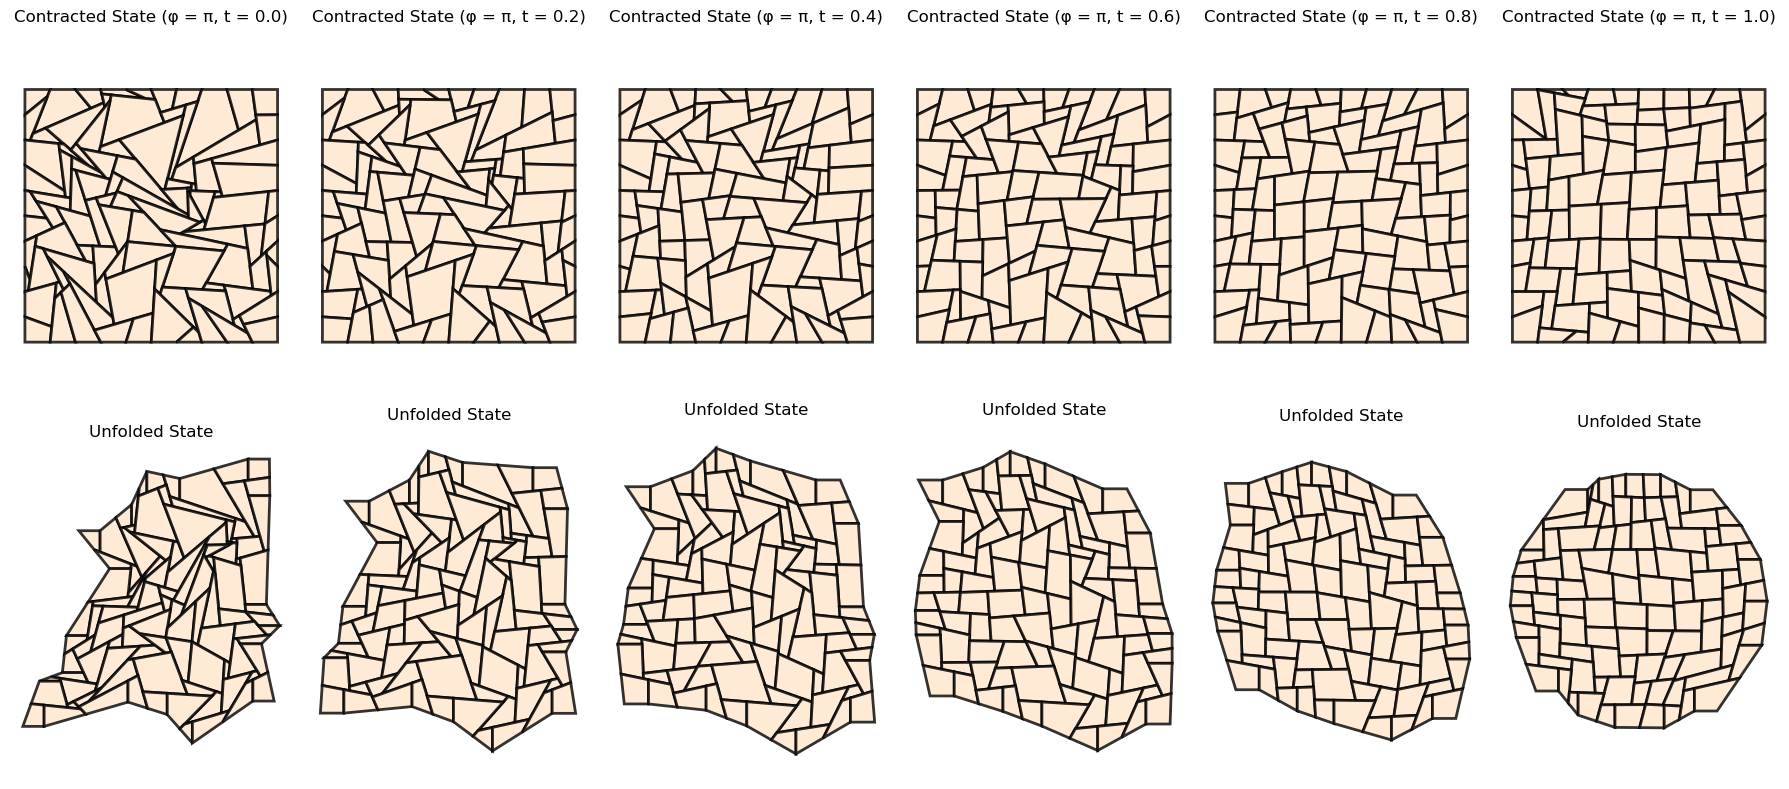

In [34]:
T = np.arange(0, 1+0.2, 0.2)
fig, axs = plt.subplots(2, len(T), figsize=(3*len(T), 8), sharey=True)
for i, t in enumerate(T):
    offset_t = t * opt_offsets + (1-t) * interior_offsets_initial
    structure.linear_inverse_design(np.vstack(boundary_points), corners, offset_t, boundary_offsets)

    deployed_points, deployed_hinge_contact_points = structure.layout(np.pi)
    deployed_points = rotate_points(deployed_points, np.array([0, 0]), -(np.pi - np.pi)/2.0)

    deployed_points[:,0] = deployed_points[:,0] - (np.max(deployed_points[:,0])+np.min(deployed_points[:,0]))/2
    deployed_points[:,1] = deployed_points[:,1] - (np.max(deployed_points[:,1])+np.min(deployed_points[:,1]))/2

    plot_structure(deployed_points, structure.quads, structure.linkages, axs[0, i])
    axs[0, i].set_aspect('equal')
    axs[0, i].set_title(f"Contracted State (φ = π, t = {t:.1f})")

    deployed_points, deployed_hinge_contact_points = structure.layout(0)
    deployed_points = rotate_points(deployed_points, np.array([0, 0]), -(np.pi - 0)/2.0)

    deployed_points[:,0] = deployed_points[:,0] - (np.max(deployed_points[:,0])+np.min(deployed_points[:,0]))/2
    deployed_points[:,1] = deployed_points[:,1] - (np.max(deployed_points[:,1])+np.min(deployed_points[:,1]))/2

    plot_structure(deployed_points, structure.quads, structure.linkages, axs[1, i])
    axs[1, i].set_aspect('equal')
    axs[1, i].set_title(f"Unfolded State")

# tighten layout
plt.tight_layout()